# Missouri Crop Yield Prediction using Remote Sensing


## Introduction
From this project, I want to predict the trend of the crop yield using NDVI(Normalized Difference Vegetation Index) from landsat imagery in Missouri. To do this, the actual Missouri crop production data and Missouri USGS landsat imagery are required to calcuate NDVI with infrared band and red band, and compare the trend of two results. 
As we have county-level Missouri's crop yield data from year of 2018 to 2020, I compared those 3 years. 
 1. Data Sources
 2. Data Loading - Polygon, Crop production data and Landsat images
 3. Data Processing - Data cleaning, Raster image downsampling and stadardization
 4. Visualization
 5. NDVI calculation
 6. Relationship between actual crop yield and NDVI
 7. Conclusion

## Consideration before analysis:
### Crop type, Crop location, Harvest time for selection of landsat

- Collected Corns and Soybeans production which occupied most of Missouri crop production.
    (93.5% of production are from corns and soybeans in year of 2019, and 93.1% in year of 2018) 
    (https://www.morningagclips.com/missouri-crop-production/)
- Selected one landsat which includes the central parts of Missouri cultivated areas. From the research, the southern parts of Missouri are forest areas, and the northern parts of Missouri are cultivated areas as below reference site. 
   (Farm land: https://www.nass.usda.gov/Research_and_Science/web_stratamaps/state-jpgs/mo_strata_15_c.jpg)
   (Forest: https://www.fs.fed.us/nrs/pubs/ru/ru_fs146.pdf)
- September landsats has been collected because Corns and Soybeans are harvested from June to September every year, and USGS has same landsat location for 3 years. Earlier priod of the satisfied landsats was not found for same location (There was difficulty to find out same location landsats with low cloud percentage 3 years in a row). The landsat of year 2019 includes some clouds which made difficulty to do prediction.


## DATA Sources
1. Missouri Crop Production by county: https://www.nass.usda.gov/Statistics_by_State/Missouri/Publications/County_Estimates/
2. Missouri geojson polygon by county: https://data.mo.gov/Demographics/Missouri-County-Boundaries-Map/n34b-fwqr
2. Missouri Landsat TIF data : https://earthexplorer.usgs.gov/





## Audience

Audience can be the teams in the company, investigating the crop harvest prediction and the crop growing status using satlite image. 
They will see the status of crop production in Missouri and consider the the prediction of crop harvest using satlite landsat image. 


## Data Loading


In [1]:
# pip install rasterstats

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import sys
import os
import urllib.request
import shutil
from pathlib import Path
from zipfile import ZipFile
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear

import rasterio
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.enums import Resampling
from rasterstats import zonal_stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [3]:
# Missouri polygons
df_mo_polygon = gpd.read_file('../exercises/Data/Missouri_County_Boundaries_Map.geojson')
geojson_mo = json.load(open('../exercises/Data/Missouri_County_Boundaries_Map.geojson'))

# Crop production by county in Missouri
df_crop = pd.read_csv('../exercises/Data/MO-CropsByCounty.csv')


# 3 years landsat image with band 4 and 5 (year 2018, 2019, 2020) for same location in Missouri
path_red33_sep_2020 = '../exercises/Data/LC08_L1TP_025033_20200905_20200918_01_T1_B4.TIF'
newpath_red33_sep_2020 ='../exercises/Data/new_red33_sep_2020_down.TIF'

path_infr33_sep_2020 = '../exercises/Data/LC08_L1TP_025033_20200905_20200918_01_T1_B5.TIF'
newpath_infr33_sep_2020 = '../exercises/Data/new_infr33_sep_2020_down.TIF'
  
path_red33_sep_2019 = '../exercises/Data/LC08_L1TP_025033_20190919_20190926_01_T1_B4.TIF'
newpath_red33_sep_2019 ='../exercises/Data/new_red33_sep_2019_down.TIF'

path_infr33_sep_2019 = '../exercises/Data/LC08_L1TP_025033_20190919_20190926_01_T1_B5.TIF'
newpath_infr33_sep_2019 = '../exercises/Data/new_infr33_sep_2019_down.TIF'


path_red33_sep_2018 = '../exercises/Data/LC08_L1TP_025033_20180916_20180928_01_T1_B4.TIF'
newpath_red33_sep_2018 ='../exercises/Data/new_red33_sep_2018_down.TIF'

path_infr33_sep_2018 = '../exercises/Data/LC08_L1TP_025033_20180916_20180928_01_T1_B5.TIF'
newpath_infr33_sep_2018 = '../exercises/Data/new_infr33_sep_2018_down.TIF'

# Spring Data to compare with September
path_red33_mar_2020 = '../exercises/Data/LC08_L1TP_025033_20200329_20200409_01_T1_B4.TIF'
newpath_red33_mar_2020 = '../exercises/Data/new_red33_mar_2020_down.TIF'

path_infr33_mar_2020 = '../exercises/Data/LC08_L1TP_025033_20200329_20200409_01_T1_B5.TIF'
newpath_infr33_mar_2020 = '../exercises/Data/new_infr33_mar_2020_down.TIF'

## Vet Data Sources


In [4]:
# Missouri polygon
df_mo_polygon.head(2)

co_class          acres pop_1990  cnty_seat countyname name_ucase  \
0        3  327632.419997     7547     Kahoka      Clark      CLARK   
1        3  351990.513001     7457  Rock Port   Atchison   ATCHISON   

  countygnis countyfips pop_2000      sq_miles  \
0     758477        045     7416  511.92565625   
1     758457        005     6430  549.98517656   

                                            geometry  
0  MULTIPOLYGON (((-91.72916 40.61370, -91.72119 ...  
1  MULTIPOLYGON (((-95.20234 40.57846, -95.20239 ...

<AxesSubplot:>

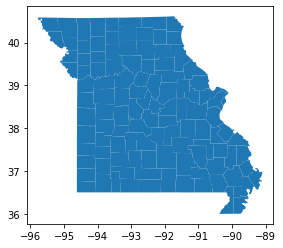

In [5]:
df_mo_polygon.plot()

In [6]:
# Actual Crop production by county
print(df_crop.info())
df_crop.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   County and State  382 non-null    object 
 1   Area planted      382 non-null    object 
 2   Area harvested    382 non-null    object 
 3   Yield per acre    382 non-null    float64
 4   Production        382 non-null    object 
 5   Crop              382 non-null    object 
 6   Year              382 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 21.0+ KB
None


County and State Area planted Area harvested  Yield per acre  Production  \
0           Adair        19,700         18,600           176.1   3,275,000   
1         Andrew         59,700         57,800           174.2  10,069,000   

   Crop  Year  
0  Corn  2020  
1  Corn  2020

In [7]:
# Read landset imagery
with rasterio.open(path_infr33_sep_2018) as src:
    band = src.read()
    print("Dtype:", src.dtypes,'\n', "CRS:", src.crs, '\n', src.bounds, '\n'
          , "Number of band:", src.count,'\n', "Shape:", src.shape)
    print("min:{}, max:{}, mean:{}".format(band.min(),band.max(),band.mean()))

Dtype: ('uint16',) 
 CRS: EPSG:32615 
 BoundingBox(left=445185.0, bottom=4188585.0, right=676215.0, top=4423215.0) 
 Number of band: 1 
 Shape: (7821, 7701)
min:0, max:65535, mean:11246.827792254897


## Data Processing and Functions


#### Missouri Crop Yield Data

In [8]:
# Data Cleaning and make same format with geojson file for county name

df_crop.rename({'County and State':'county','Area planted':'area_planted'
                ,'Area harvested':'area_harvested','Yield per acre':'yield_per_acre'
                ,'Production':'production(m)','Crop':'crops','Year':'year'}, axis=1, inplace=True)

df_crop = df_crop.replace(',','',regex=True)
df_crop['production(m)'] = df_crop['production(m)'].astype('float')
df_crop['production(m)'] = df_crop['production(m)']/1000000  # change the number to million.
df_crop['production(m)'] = round(df_crop['production(m)'],2)


In [9]:
# Change data type
def to_num(col):
    df_crop[col]=pd.to_numeric(df_crop[col])

to_num('area_planted')
to_num('area_harvested')


In [10]:
# County values have empty space. Remove the space.
df_crop['county']=df_crop['county'].apply(lambda x:x.strip())    

# Make same format(DeKalb--> Dekalb)
df_crop.replace('DeKalb','Dekalb', inplace=True)
df_crop['year']=df_crop['year'].astype('str')

df_crop.head()

county  area_planted  area_harvested  yield_per_acre  production(m)  \
0     Adair         19700           18600           176.1           3.28   
1    Andrew         59700           57800           174.2          10.07   
2  Atchison        136000          132100           206.6          27.29   
3   Audrain        112500          106400           178.1          18.95   
4     Barry          5400            3920           101.5           0.40   

  crops  year  
0  Corn  2020  
1  Corn  2020  
2  Corn  2020  
3  Corn  2020  
4  Corn  2020

In [11]:
df_crop['crops'].unique()

array(['Corn', 'Soybeans'], dtype=object)

In [12]:
# 3 years overall Corn and Soybeans production by county 
df_crop_cnty = df_crop.groupby('county')['production(m)'].sum().reset_index()
df_crop_cnty.head()

county  production(m)
0     Adair           9.58
1    Andrew          13.51
2  Atchison          63.97
3   Audrain          74.14
4     Barry           1.39

#### Calculate each county's centroid and add to the map for top 5 counties 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


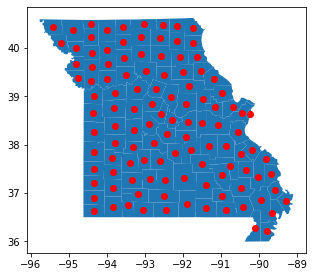

In [13]:
df_mo_centroid = gpd.GeoSeries(df_mo_polygon.centroid)
df_mo_polygon['df_mo_centroid'] = df_mo_polygon.to_crs('epsg:4326').centroid

f, ax = plt.subplots(1, figsize=(5,5))
df_mo_polygon.plot(ax=ax)
df_mo_centroid.plot(ax=ax, color='red') 

plt.show()


In [14]:
# Find top 5 counties and add the centroid. Crop Production table doesn't have geometry.
df_crop_top5= df_crop_cnty.sort_values(by=['production(m)']).tail(5)
df_crop_top5= df_crop_top5.merge(df_mo_polygon[['countyname', 'df_mo_centroid']], left_on='county',right_on='countyname')
df_crop_top5

county  production(m) countyname              df_mo_centroid
0   Atchison          63.97   Atchison  POINT (-95.42803 40.43083)
1   Stoddard          65.19   Stoddard  POINT (-89.94427 36.85560)
2    Audrain          74.14    Audrain  POINT (-91.84164 39.21571)
3  Lafayette          74.48  Lafayette  POINT (-93.78556 39.06554)
4     Saline          96.88     Saline  POINT (-93.20187 39.13678)

In [15]:
# Colormap scale using min and mix of production
colormap = linear.YlGn_03.scale(
    df_crop_cnty['production(m)'].min(),
    df_crop_cnty['production(m)'].max())

print(colormap(5.))

colormap

#f0f9b5ff


### Functions for data processing and plot
- Folium plot
- Downsizing, standardizing raster files and saving to dataframe
- Calculating NDVI
- Plot NDVI raster 

In [16]:
# Creating Choropleth. Gray areas are wood areas
# Annotate top 5 counties

m = folium.Map(location=[38.2217, -92.2913], tiles="cartodbpositron", zoom_start=6)

production_series = df_crop_cnty.set_index("county")["production(m)"]

def style_function(feature):
    production = production_series.get(feature['properties']['countyname'], None)
    return {
        "fillOpacity": 0.9,
        "weight": 1,
        "fillColor": "#bdbdbd" if production is None else colormap(production),
    }
    

folium.GeoJson(geojson_mo,
              name='Choropleth',
               style_function=style_function
              ).add_to(m)


for index, row in df_crop_top5.iterrows():
    label = '<i>' + row['county'] + '</i>'
    folium.Marker([row['df_mo_centroid'].y, row['df_mo_centroid'].x],popup=label).add_to(m)



In [17]:
# Choropleth map with color by crop production in 2020 and markers for top 5 counties
# When click the markers, you can see the county name.
# Gray area is no farm land. 
m       

#### Landsat Data - downsampling and standardize

In [18]:
# open, read, downsampling, standardize, plot raster files and save details to dataframe
summary ={"org_file":[], "org_min":[], "org_max":[],"org_mean":[], "org_bandcnt":[], 
          "org_shape":[], "org_crs":[],"new_file":[], "new_min":[], "new_max":[],
          "new_mean":[], "new_shape":[], "new_band":[]}

def open_to_stdrd(path, new_path):
    # open, read
    src=rasterio.open(path)
    band=src.read()
    
    #downsampling
    height = round(band.shape[1]/10)  
    width = round(band.shape[2]/10)   
    downsampled = np.empty(shape = (band.shape[0], height, width), dtype = np.uint16)

    with rasterio.open(path) as dataset:
        dataset.read(out = downsampled, resampling=Resampling.average)

        # The pixels are going to scale to 10x from 30 m to 300 m
        dst_transform = dataset.transform * Affine.scale(10,10)
        print(dst_transform)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': dst_transform,
            'width' : width,
            'height': height
        })

    with rasterio.open(new_path,'w', **kwargs) as dst:
        dst.write(downsampled)
        
    with rasterio.open(new_path) as src_new:
        band_new =src_new.read()
        fig = plt.figure(figsize=(6,6))
        rasterio.plot.show(src_new.read(), title = str(new_path)[18:])
    
    # Standardization
        band_down_std = (band_new - band_new.min())/(band_new.max() - band_new.min())

        summary['org_file'].append(path)
        summary['org_min'].append(band.min())
        summary['org_max'].append(band.max())
        summary['org_mean'].append(band.mean())
        summary['org_shape'].append(src.shape)
        summary['org_crs'].append(src.crs)
        summary['org_bandcnt'].append(src.count)  # save original raster values
       
        summary['new_file'].append(new_path)
        summary['new_min'].append(band_down_std.min())
        summary['new_max'].append(band_down_std.max())
        summary['new_mean'].append(band_down_std.mean())
        summary['new_shape'].append(band_down_std.shape)
        summary['new_band'].append(band_down_std)   # save raster values after standardization
        


#### Calculate NDVI values

In [19]:
# Return 3 NDVI value - Original NDVI, NDVI with no vegi to 0, NDVI with 0 and 0
def ndvi_val(redband, nirband):
    nirband = nirband.astype(np.float64)
    redband = redband.astype(np.float64)
    ndvi = (nirband - redband)/(nirband + redband+0.0000000000001) 
    
    # Keep only NDVI vagitation values
    ndvi_vegi = np.copy(ndvi)    
    ndvi_vegi[ndvi_vegi<0.3]=0      # Keep vagitation values and others to 0 
  
   #Threshold NDVI
    ndvi_vegi_1 = np.copy(ndvi)
    ndvi_vegi_1[ndvi_vegi_1>=0.3]=1     # Consider as Vegitation 
    ndvi_vegi_1[ndvi_vegi_1<0.3]=0      # Others
    
    return ndvi, ndvi_vegi, ndvi_vegi_1

#### Visualize NDVI original value and NDVI threshold value

In [20]:
def ndvi_plot(ndvi, ndvi_vegi_1, title):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 8), sharey=True)
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    rasterio.plot.show(ndvi, cmap='RdYlGn', ax=ax1) # Plot before threadhold
  
    #Threshold NDVI
    fig = plt.figure(figsize=(10,10))  
    rasterio.plot.show(ndvi_vegi_1,cmap='RdYlGn', ax=ax2)  # Plot after applying threadhold

    # Add titles
    ax1.set_title("Orignal NDVI Band")
    ax2.set_title("Threshold NDVI Band")

## Visualizations


#### MO actual crop yield from 2018 to 2020

Text(0, 0.5, 'Production(m)')

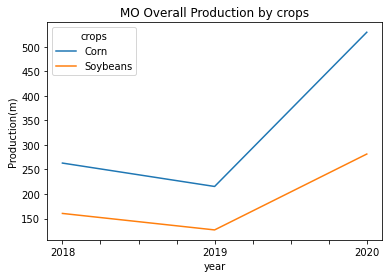

In [21]:
# Overall MO crop production trend per year
df_crop.groupby(['year','crops'])['production(m)'].sum().unstack().plot(title ='MO Overall Production by crops').set_ylabel("Production(m)")


In [22]:
df_crop.head()

county  area_planted  area_harvested  yield_per_acre  production(m)  \
0     Adair         19700           18600           176.1           3.28   
1    Andrew         59700           57800           174.2          10.07   
2  Atchison        136000          132100           206.6          27.29   
3   Audrain        112500          106400           178.1          18.95   
4     Barry          5400            3920           101.5           0.40   

  crops  year  
0  Corn  2020  
1  Corn  2020  
2  Corn  2020  
3  Corn  2020  
4  Corn  2020

Text(0, 0.5, 'Production(m)')

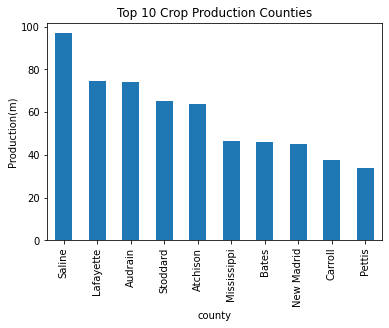

In [23]:
# Top 10 counties for production
df_crop.groupby(['county'])['production(m)'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title = "Top 10 Crop Production Counties").set_ylabel("Production(m)")


#### The relationship between farm areas and production. It has very linear relationship.  
- Farm size and crop production have strong linear relationship
- We can predict the production based on the farm areas

[Text(0.5, 1.0, '2020')]

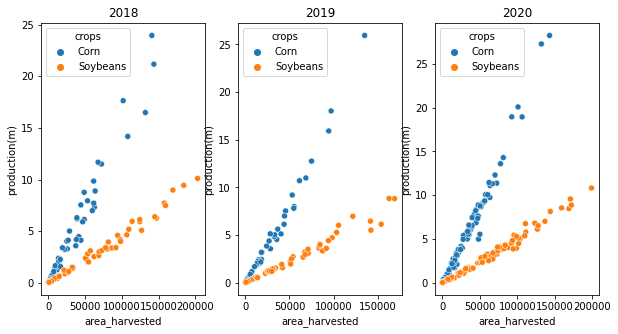

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(10,5))
sns.scatterplot(data=df_crop[df_crop.year=='2018'], x='area_harvested', y='production(m)', hue='crops', ax=axs[0])\
                .set(title='2018')
sns.scatterplot(data=df_crop[df_crop.year=='2019'], x='area_harvested', y='production(m)', hue='crops', ax=axs[1])\
                .set(title='2019')
sns.scatterplot(data=df_crop[df_crop.year=='2020'], x='area_harvested', y='production(m)', hue='crops', ax=axs[2])\
                .set(title='2020')

#### Downsizing and standardizing plots of Landsat images - redband and infrared band

| 300.00, 0.00, 445185.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


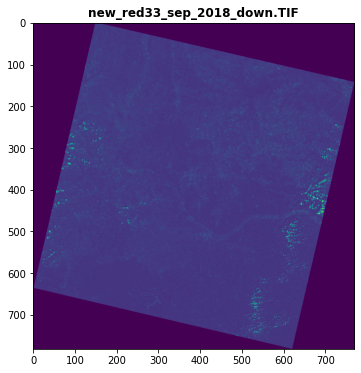

| 300.00, 0.00, 445185.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


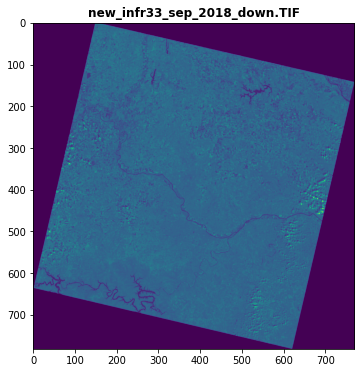

| 300.00, 0.00, 444285.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


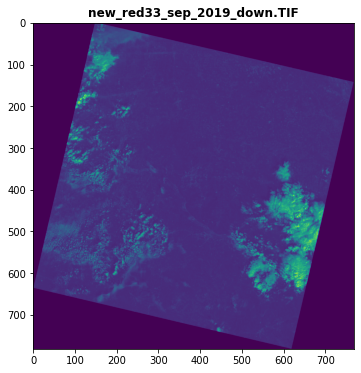

| 300.00, 0.00, 444285.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


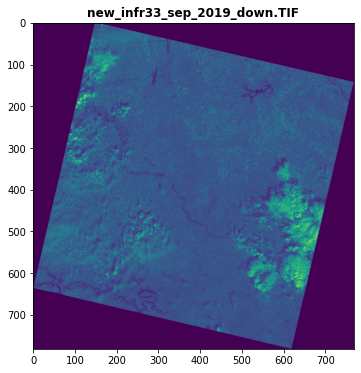

| 300.00, 0.00, 443985.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


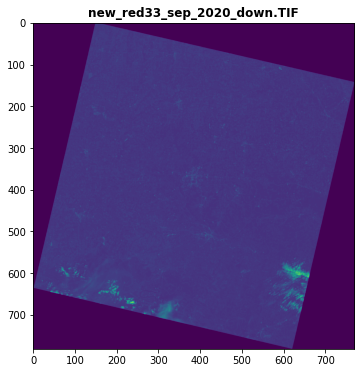

| 300.00, 0.00, 443985.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


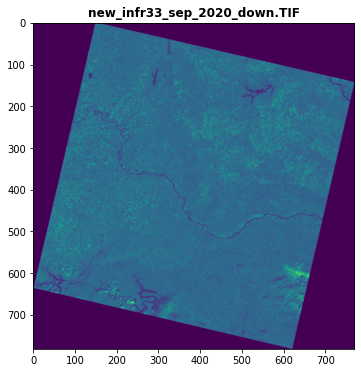

In [26]:
# Open redband and infrared band, downsize, standardize and plot the updated raster. Save to dataframe 
# Below plots are downsized ones. 
open_to_stdrd(path_red33_sep_2018, newpath_red33_sep_2018)    # redband for Sep. 2018
open_to_stdrd(path_infr33_sep_2018, newpath_infr33_sep_2018)  # infrared band for Sep. 2018
open_to_stdrd(path_red33_sep_2019, newpath_red33_sep_2019)    # redband for Sep. 2019. Some clouds included.
open_to_stdrd(path_infr33_sep_2019, newpath_infr33_sep_2019)  # infrared band for Sep. 2019. Some clouds included.
open_to_stdrd(path_red33_sep_2020, newpath_red33_sep_2020)    # redband for Sep. 2020
open_to_stdrd(path_infr33_sep_2020, newpath_infr33_sep_2020)  # infrared band for Sep. 2020

| 300.00, 0.00, 442485.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


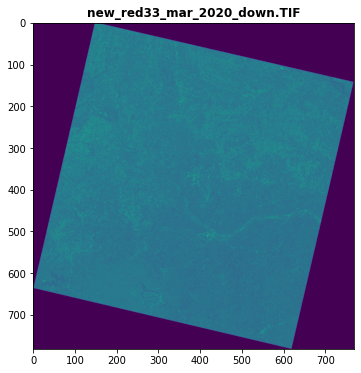

| 300.00, 0.00, 442485.00|
| 0.00,-300.00, 4423215.00|
| 0.00, 0.00, 1.00|


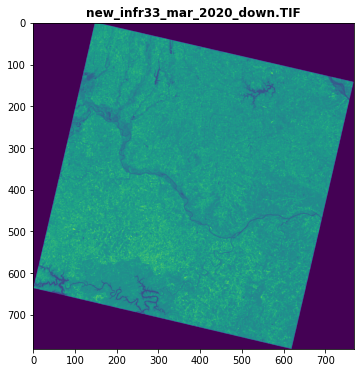

In [27]:
# Compare with Spring time for crop status
open_to_stdrd(path_red33_mar_2020, newpath_red33_mar_2020)    # redband for March 2020
open_to_stdrd(path_infr33_mar_2020, newpath_infr33_mar_2020)  # infrared band for March 2020

In [28]:
# convert raster infor to dataframe 
df_raster = pd.DataFrame(summary)
df_raster.head(3)

org_file  org_min  org_max  \
0  ../exercises/Data/LC08_L1TP_025033_20180916_20...        0   -12175   
1  ../exercises/Data/LC08_L1TP_025033_20180916_20...        0       -1   
2  ../exercises/Data/LC08_L1TP_025033_20190919_20...        0       -1   

       org_mean  org_bandcnt     org_shape org_crs  \
0   5175.692194            1  (7821, 7701)  (init)   
1  11246.827792            1  (7821, 7701)  (init)   
2   6866.035120            1  (7821, 7691)  (init)   

                                         new_file  new_min  new_max  new_mean  \
0   ../exercises/Data/new_red33_sep_2018_down.TIF      0.0      1.0  0.117948   
1  ../exercises/Data/new_infr33_sep_2018_down.TIF      0.0      1.0  0.227996   
2   ../exercises/Data/new_red33_sep_2019_down.TIF      0.0      1.0  0.116990   

       new_shape                                           new_band  
0  (1, 782, 770)  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
1  (1, 782, 770)  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
2  (1, 782, 769)  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

#### We can compare NDVI landsat results every year from 2018 to 2020, and see which year had more crop production.
1. Red-Yellow-Green color map. 
2. More green more vegetation. We have to see the upper side of Missouri river which have farm areas.
3. Year 2018: Original NDVI image shows overall yellow compared to rest of years. When it converted to threshold NDVI, it become one green area.
4. Year 2019: more green color than 2018, but due to cloud it doesn't appear all area correctly. 
5. Year 2020: overall green color

In [29]:
# To get ndvi values: ndvi is original ndvi calculation values, ndvi_vegi converts non-vegitation to o others remain same.
# ndvi_vegi1 convert vegitation to 1, others to 0.
ndvi_2018, ndvi_vegi_2018, ndvi_vegi1_2018 = ndvi_val(df_raster['new_band'][0], df_raster['new_band'][1])
ndvi_2019, ndvi_vegi_2019, ndvi_vegi1_2019 = ndvi_val(df_raster['new_band'][2], df_raster['new_band'][3])
ndvi_2020, ndvi_vegi_2020, ndvi_vegi1_2020 = ndvi_val(df_raster['new_band'][4], df_raster['new_band'][5])

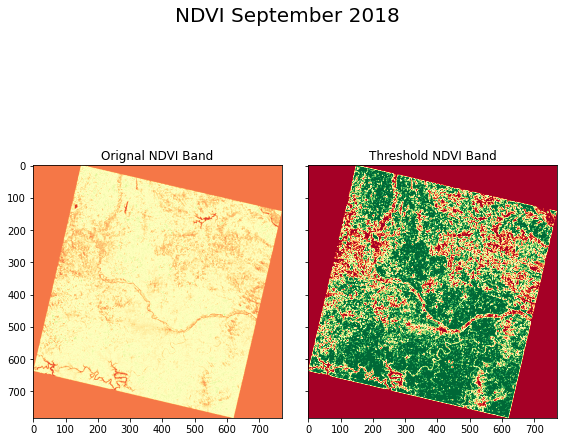

<Figure size 720x720 with 0 Axes>

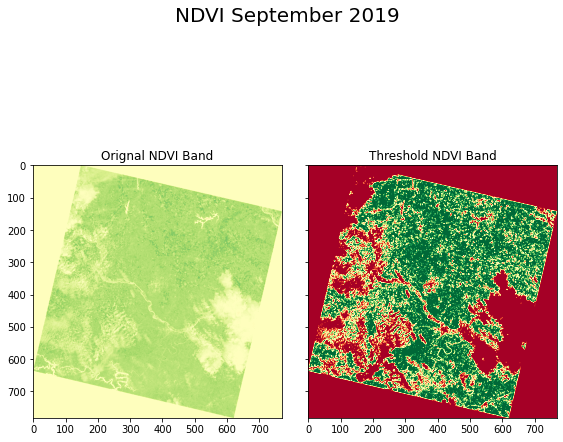

<Figure size 720x720 with 0 Axes>

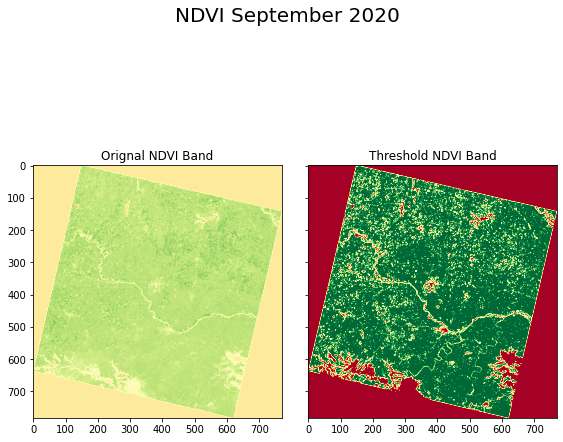

<Figure size 720x720 with 0 Axes>

In [30]:
# NDVI results per each year. Compare Crop status per year in Missouri center areas.
# Compare orignal NDVI with NDVI values after threshold
ndvi_plot(ndvi_2018,ndvi_vegi1_2018,'NDVI September 2018')
ndvi_plot(ndvi_2019,ndvi_vegi1_2019,'NDVI September 2019')
ndvi_plot(ndvi_2020,ndvi_vegi1_2020,'NDVI September 2020')

##### Compare with March time for same landsat areas. In the original NDVI image, the green color is very week. So threshold NDVI color is mostly red which means rarely found vegetation on that area in march. 

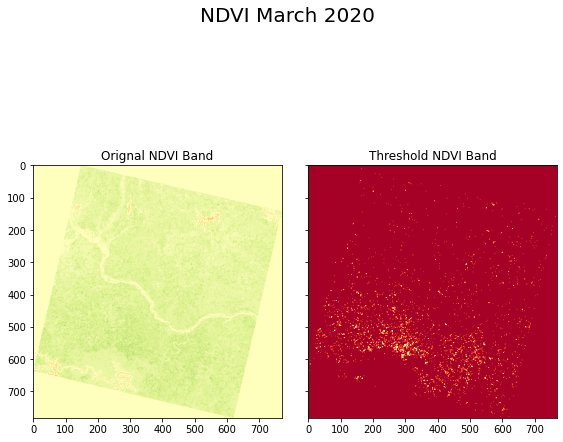

<Figure size 720x720 with 0 Axes>

In [31]:
# In March, hardly see the crop in the farm areas, which is very diffrent results from September results.
# To get ndvi values
ndvi_mar2020, ndvi_vegi_mar2020, ndvi_vegi1_mar2020 = ndvi_val(df_raster['new_band'][6], df_raster['new_band'][7])
ndvi_plot(ndvi_mar2020,ndvi_vegi1_mar2020,'NDVI March 2020')

## Define target counties for crop yield prediction
- Convert CRS to all required data

In [32]:
# Convert MO polygon's CRS to 32615
print("Landsat CRS: ", rasterio.open(newpath_red33_sep_2020).crs)
print("Original Polygon CRS: ", df_mo_polygon.crs)
print(" ")
print("After converting CRS to 32615 :")
df_mo_poly_32615 = df_mo_polygon.to_crs('epsg:32615')
df_mo_poly_32615.crs

Landsat CRS:  EPSG:32615
Original Polygon CRS:  epsg:4326
 
After converting CRS to 32615 :


<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
# Top5 crop production table
type(df_crop_top5)
df_crop_top5

county  production(m) countyname              df_mo_centroid
0   Atchison          63.97   Atchison  POINT (-95.42803 40.43083)
1   Stoddard          65.19   Stoddard  POINT (-89.94427 36.85560)
2    Audrain          74.14    Audrain  POINT (-91.84164 39.21571)
3  Lafayette          74.48  Lafayette  POINT (-93.78556 39.06554)
4     Saline          96.88     Saline  POINT (-93.20187 39.13678)

In [34]:
# Convert top5 production table to geodataframe so that change point CRS to 32615 
gdf_crop_top5 = gpd.GeoDataFrame(
    df_crop_top5, geometry= df_crop_top5['df_mo_centroid'])

In [35]:
# As there is no provided crs, set crs
gdf_crop_top5 = gdf_crop_top5.set_crs('epsg:4326')
gdf_crop_top5.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
# change point CRS to 32615 
gdf_crop_top5_32615 = gdf_crop_top5.to_crs('epsg:32615')
gdf_crop_top5_32615.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
# Drop unnecessary columns
gdf_crop_top5_32615 = gdf_crop_top5_32615.drop(['countyname','df_mo_centroid'], axis=1)
gdf_crop_top5_32615

county  production(m)                        geometry
0   Atchison          63.97  POINT (294042.576 4478407.451)
1   Stoddard          65.19  POINT (772436.341 4083213.765)
2    Audrain          74.14  POINT (600000.136 4341353.432)
3  Lafayette          74.48  POINT (432039.189 4324343.158)
4     Saline          96.88  POINT (482553.612 4331974.300)

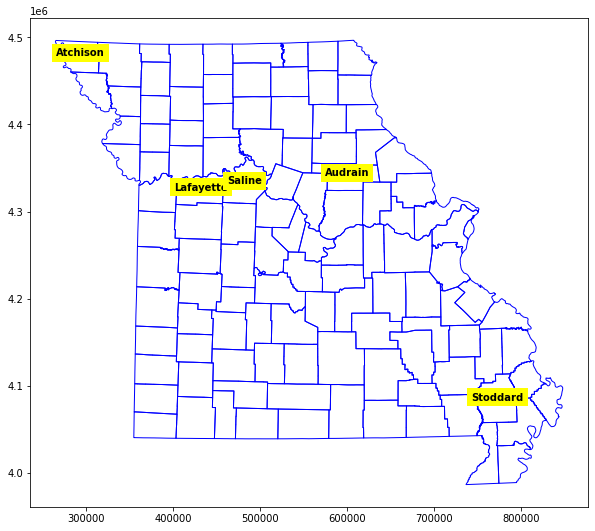

In [38]:
# Annotate top5 crop production counties on the map
df_mo_poly_32615.plot(facecolor='none', edgecolor='blue', figsize=(10,10))
for i in range(len(gdf_crop_top5_32615)): 
    plt.text(float(gdf_crop_top5_32615['geometry'][i].x)
             ,float(gdf_crop_top5_32615['geometry'][i].y), s= gdf_crop_top5_32615['county'][i]
           ,horizontalalignment='center', fontsize ='medium', weight = 'bold'
             , bbox={'facecolor': 'yellow', 'edgecolor':'none'}
            )

#### From top 5 county, Saline and Audrain county include to the imagery file, thus we will see the crop production trend on these two countries. 

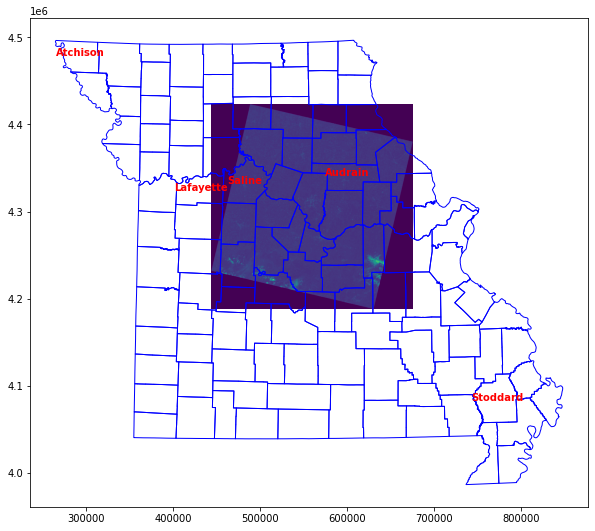

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(rasterio.open(newpath_red33_sep_2020), ax=ax)
df_mo_poly_32615.plot(facecolor='none', edgecolor='blue', figsize=(10,10), ax=ax)
for i in range(len(gdf_crop_top5_32615)): 
    plt.text(float(gdf_crop_top5_32615['geometry'][i].x)
             ,float(gdf_crop_top5_32615['geometry'][i].y), s= gdf_crop_top5_32615['county'][i]
           ,horizontalalignment='center', fontsize ='medium', weight = 'bold', color = 'red'
#              , bbox={'facecolor': 'yellow', 'edgecolor':'none'}
            )

## Calculate NVDI mean for target counties

In [40]:
# Select only Audrain and Saline geometry data which are in the top 3 list. 
shp_32615_sel = df_mo_poly_32615[(df_mo_poly_32615.countyname=='Audrain') | (df_mo_poly_32615.countyname=='Saline')]
shp_32615_sel

co_class          acres pop_1990 cnty_seat countyname name_ucase  \
36        3  445651.750121    23599    Mexico    Audrain    AUDRAIN   
37        4  490452.589356    23523  Marshall     Saline     SALINE   

   countygnis countyfips pop_2000      sq_miles  \
36     758458        007    25853  696.33085956   
37     758550        195    23756  766.33217087   

                                             geometry  \
36  MULTIPOLYGON (((579111.014 4354966.460, 580861...   
37  MULTIPOLYGON (((488567.735 4358665.197, 488651...   

                df_mo_centroid  
36  POINT (-91.84164 39.21571)  
37  POINT (-93.20187 39.13678)

In [41]:
# transform information for zonal statistics
transform_2018 = rasterio.open(df_raster['new_file'][0]).transform
transform_2019 = rasterio.open(df_raster['new_file'][2]).transform
transform_2020 = rasterio.open(df_raster['new_file'][4]).transform

In [42]:
transform_2018

Affine(300.0, 0.0, 445185.0,
       0.0, -300.0, 4423215.0)

#### NDVI vegitation value means(before threshold) for targget counties 

In [43]:
# zonal statistic to get means only for Saline and Audrain counties
zonal_vegi_2018 = zonal_stats(shp_32615_sel['geometry'], ndvi_vegi_2018[0], affine=transform_2018, stats=["mean"])
zonal_vegi_2019 = zonal_stats(shp_32615_sel['geometry'], ndvi_vegi_2019[0], affine=transform_2019, stats=["mean"])
zonal_vegi_2020 = zonal_stats(shp_32615_sel['geometry'], ndvi_vegi_2020[0], affine=transform_2020, stats=["mean"])

/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.7/site-

In [44]:
list = [zonal_vegi_2018, zonal_vegi_2019, zonal_vegi_2020 ]
year = ['2018', '2019', '2020' ]
zonal_ndvi_vegi_mean = {"Audrain":[], "Saline":[], "Year":[]}
for i in range(3):   
    zonal_ndvi_vegi_mean['Year'].append(year[i])
    zonal_ndvi_vegi_mean['Audrain'].append(list[i][0]['mean'])
    zonal_ndvi_vegi_mean['Saline'].append(list[i][1]['mean'])
df_ndvi_vegi_mean = pd.DataFrame(zonal_ndvi_vegi_mean)
df_ndvi_vegi_mean

Audrain    Saline  Year
0  0.175104  0.126833  2018
1  0.343333  0.099917  2019
2  0.389275  0.296368  2020

##### ndvi vegitation value to dataframe per year for Audrain and Saline

In [45]:
# To transform the table for visualization
df_ndvi_vegi_means = df_ndvi_vegi_mean.melt(id_vars='Year', var_name='county',value_name='ndvi')
df_ndvi_vegi_means

Year   county      ndvi
0  2018  Audrain  0.175104
1  2019  Audrain  0.343333
2  2020  Audrain  0.389275
3  2018   Saline  0.126833
4  2019   Saline  0.099917
5  2020   Saline  0.296368

## Plot for actual production and NDVI means 

In [46]:
# Actual crop production
df_crop_sel = df_crop[(df_crop['county']=='Audrain')| (df_crop['county']=='Saline')].groupby(['county','year'])['production(m)'].sum().reset_index()
df_crop_sel

county  year  production(m)
0  Audrain  2018          21.90
1  Audrain  2019          24.74
2  Audrain  2020          27.50
3   Saline  2018          27.57
4   Saline  2019          32.91
5   Saline  2020          36.40

In [47]:
# Combine actional production and NDVI tables
df_ndvi_comb = pd.concat([df_crop_sel, df_ndvi_vegi_means['ndvi']], axis=1)
df_ndvi_comb

county  year  production(m)      ndvi
0  Audrain  2018          21.90  0.175104
1  Audrain  2019          24.74  0.343333
2  Audrain  2020          27.50  0.389275
3   Saline  2018          27.57  0.126833
4   Saline  2019          32.91  0.099917
5   Saline  2020          36.40  0.296368

##### As production is increase, mean of ndvi should be also increase. Audrain follow quite linear but Saline doesn't follow linearity. It is assumed that the amount of cloud in 2019 affects the remote sensing value which contribute low ndvi values. 

[Text(0.5, 1.0, 'Saline')]

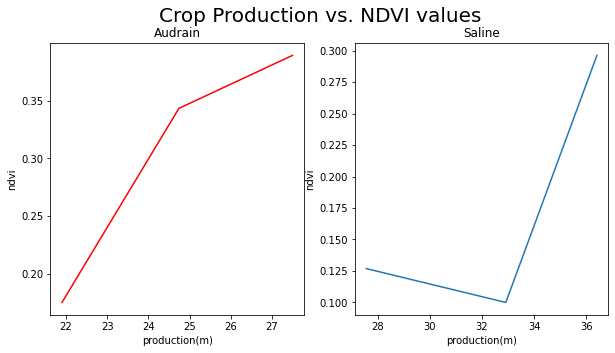

In [48]:
# Plot the rlationship between actual crop production and ndvi values
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
fig.suptitle('Crop Production vs. NDVI values', fontsize=20)
sns.lineplot(data=df_ndvi_comb[df_ndvi_comb['county']=='Audrain'], x='production(m)', y='ndvi', color='red', ax=ax1).set(title='Audrain')
sns.lineplot(data=df_ndvi_comb[df_ndvi_comb['county']=='Saline'],  x='production(m)', y='ndvi', ax=ax2).set(title='Saline')

In [49]:
gdf_crop_top5_32615[gdf_crop_top5_32615.county=='Saline']['geometry']

4    POINT (482553.612 4331974.300)
Name: geometry, dtype: geometry

<AxesSubplot:title={'center':'Cloudy weather on imagery in 2019, Red point is Saline'}>

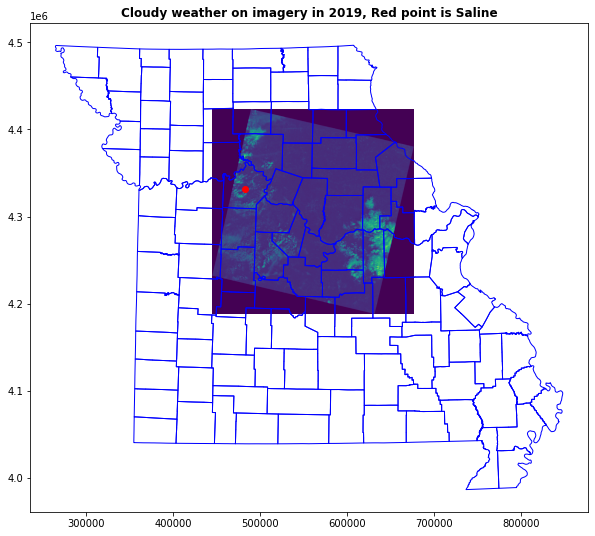

In [50]:
# Cloud in Saline sky on the year of 2019
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(rasterio.open(newpath_red33_sep_2019), title = 'Cloudy weather on imagery in 2019, Red point is Saline',ax=ax)
df_mo_poly_32615.plot(facecolor='none', edgecolor='blue', figsize=(10,10), ax=ax)
gdf_crop_top5_32615[gdf_crop_top5_32615.county=='Saline']['geometry'].plot(ax=ax, color='red') 



## Conclusion - Story


===========================================================================================================================

We have seen linear relationship between actual crop production and imagery ndvi values on Audrain county. But due to the cloud on the imagery, we couldn't see same trend on Saline county. Adding more counties to see the same trend would be helpful.

For further investigation to find out the solid relationship between actual crop yield and NDVI data, we need to consider below points: 
1. The consistent landsat image with same condition is very important(ex. cloud, date, location).
2. Find out the best date to estimate the crop yield before crop harvest. The landsat images after harvest have no meaning and mislead the analysis results. 
3. There should be landsat image with the lowest cloud percentage which interferes to get actual vegetation index. As you see the 2019 landsat, the cloud areas were excluded to NDVI calculation which would impact to get actual data and get prediction.  
4. We need to have the alternative way to get the landsat if there is no satisfied landsat for same location during the specified periods. It was difficult to find the same condition landsats for same location during certain period. 
5. NDVI threshold data is good to identify the presence of vegetation or crops, but not good for prediction of crop production because it gives same weight for whole areas of vegetation regardless of its amount. 
6. Isolate the crop land, and exclude the forest or other crop areas. Or we need to have another NDVI formula for the specific crop for yield prediction.
  
    

Thank you!

